In [1]:
import os
import sys 
from pyprojroot import here
sys.path.insert(0, str(here()))
from os.path import exists

import geopandas as gpd
from laos_gggi.data_functions import load_emdat_data, load_shapefile, load_rivers_data
from laos_gggi.data_functions.disaster_point_data import load_disaster_point_data, load_synthetic_non_disaster_points, load_grid_point_data

from laos_gggi.plotting import configure_plot_style
from laos_gggi.statistics import get_distance_to_rivers, prediction_to_gpd_df , set_plotting_data, add_data, add_country_effect
from laos_gggi.data_functions.combine_data import load_all_data

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import arviz as az
import scipy
import nutpie
import pathlib

import pymc as pm
import pytensor.tensor as pt
from laos_gggi.sample import sample_or_load


from laos_gggi.transformers import CenterTransform, Standardize

configure_plot_style()

# Load and prepare data

In [2]:
world = load_shapefile('world')
# rivers = load_rivers_data()
laos = world.query('ISO_A3 == "LAO"')

# Select SEA shape
laos_neighboors = ["LAO", "VNM", "KHM", "THA"]
sea_map = world.query('ISO_A3 in @laos_neighboors')

In [3]:
sea_point_grid = load_grid_point_data(region='sea', grid_size=400)
laos_point_grid = load_grid_point_data(region='laos', grid_size=100)

Loading data found at C:\Users\camil\Documents\Servicios\OCDE-GGI\laos-climate-change\data\shapefiles\sea_points_400.shp\sea_points_400.shp.shp
Loading data found at C:\Users\camil\Documents\Servicios\OCDE-GGI\laos-climate-change\data\shapefiles\laos_points_100.shp\laos_points_100.shp.shp


In [4]:
all_data = load_all_data()
panel_data  = all_data["df_panel"][['population_density', 'gdp_per_cap', 'Population', 'precip']]
co2 = all_data["df_time_series"]["co2"]

In [5]:
disasters = load_disaster_point_data()
not_disasters = load_synthetic_non_disaster_points(by='country', multiplier=3)

merged_df = pd.concat([not_disasters.assign(is_disaster = 0), 
                       disasters.reset_index().assign(is_disaster=1)], 
                      ignore_index= True)

Loading data found at C:\Users\camil\Documents\Servicios\OCDE-GGI\laos-climate-change\data\synthetic_non_disasters_country_times_3.csv


In [6]:
from statsmodels.tsa.seasonal import STL

precipitation = all_data["gpcc"]
precip_deviation = precipitation.groupby('ISO').transform(lambda x: x - x.iloc[:30].mean()).rename(columns={'precip':'precip_deviation'})

df_clim = all_data["df_time_series"][["co2", "Temp", "precip"]].iloc[1:-1].dropna(subset=['Temp'])
trend =  STL(pd.DataFrame(df_clim["Temp"].dropna()), period=3).fit().trend
dev_from_trend_ocean_temp = (df_clim['Temp'] - trend).to_frame(name='dev_ocean_temp')

In [7]:
from functools import reduce
df = reduce(lambda l, r: pd.merge(l, r, left_on=['ISO', 'Start_Year'], right_index=True, how='left'), [merged_df, panel_data, precip_deviation])
df = reduce(lambda l, r: pd.merge(l, r , left_on=['Start_Year'], right_index=True, how='left'), [df, co2, dev_from_trend_ocean_temp])

In [8]:
#Creating log variables
log_list = ["distance_to_river", "distance_to_coastline", "Total_Affected", "Total_Damage_Adjusted", "population_density",
            "gdp_per_cap"]
for y in log_list:
    df[f"log_{y}"] = np.log(df[y])

#Creating the squared log variables
df["log_population_density_squared"] = 2 * df["log_population_density"]
df["log_gdp_per_cap_squared"] = 2 * df["log_gdp_per_cap"]

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
#Delimiting data set
columns_to_use = ['ISO', 'Start_Year', "is_disaster", 'distance_to_river', 'distance_to_coastline', 'is_island',
               "Population", "co2", "precip_deviation", "dev_ocean_temp", 'population_density',
               'gdp_per_cap', "lat", "long" , "geometry"]

features = ['log_distance_to_river', 'log_distance_to_coastline',
             "Population", "co2", "precip_deviation", "dev_ocean_temp", 'log_population_density', 'log_population_density_squared',
             'log_gdp_per_cap', 'log_gdp_per_cap_squared', ]

model_df = df[ list( set( columns_to_use).union(set(features)) )].dropna()

laos_2020_data =  model_df.loc[lambda x:( x.ISO == "LAO") & (x.Start_Year == "2020")].iloc[0 ]
for feature in features:
    if feature not in laos_point_grid.columns:
        laos_point_grid[feature] = laos_2020_data[feature].item()

In [10]:
# Define list of features standardized
features_stand = []
for feature in features:
    features_stand.append(feature + "__standardized" )

time_varying_features = ['Population','co2','precip_deviation','dev_ocean_temp','log_population_density',
                            'log_population_density_squared','log_gdp_per_cap','log_gdp_per_cap_squared']
time_varying_features_stand = []

for feature in time_varying_features:
    time_varying_features_stand.append(feature + "__standardized")

### Create SEA and Laos data sets

In [11]:
#Create the geodata set for sea disasters
sea_disasters = model_df.query('ISO in @laos_neighboors & is_disaster == 1')

sea_disasters_geo = gpd.GeoDataFrame(
                sea_disasters,
    geometry=gpd.points_from_xy(sea_disasters["long"], sea_disasters["lat"]), crs="EPSG:4326"
            )


# Create the geodata set for Laos disasters
laos_disasters = model_df.query('ISO == "LAO" & is_disaster == 1')

laos_disasters_geo = gpd.GeoDataFrame(
                laos_disasters,
    geometry=gpd.points_from_xy(laos_disasters["long"], laos_disasters["lat"]), crs="EPSG:4326"
            )

In [12]:
# Merge points with world ISO
sea_point_grid_extended = gpd.sjoin(sea_point_grid, sea_map, how="left", )

In [13]:
#We define the map and the df for south east asia
sea_df = model_df.query('ISO in @laos_neighboors')

#Tranform to geopandas df
sea_df = gpd.GeoDataFrame(sea_df,  geometry=gpd.points_from_xy(sea_df["long"],
                                sea_df["lat"]),crs="EPSG:4326")

In [14]:
# Standardize data
transformer_stand_ =  Standardize().fit(sea_df)
sea_df_stand = transformer_stand_.transform(sea_df)

country_2020_data = {}
country_2020_data_df = pd.DataFrame()
for country in laos_neighboors:
    country_2020_data[country] = sea_df_stand.query('Start_Year == "2020-01-01 00:00:00" & ISO == @country').iloc[[0]][features_stand + ["ISO"]]
    country_2020_data_df = pd.concat([country_2020_data_df, country_2020_data[country]])

sea_point_grid_extended = pd.merge(sea_point_grid_extended, country_2020_data_df, how = "left", left_on= "ISO_A3", right_on="ISO" ) 

C:\Users\camil\AppData\Local\Temp\ipykernel_4144\1079096528.py:8: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  country_2020_data[country] = sea_df_stand.query('Start_Year == "2020-01-01 00:00:00" & ISO == @country').iloc[[0]][features_stand + ["ISO"]]
C:\Users\camil\AppData\Local\Temp\ipykernel_4144\1079096528.py:8: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  country_2020_data[country] = sea_df_stand.query('Start_Year == "2020-01-01 00:00:00" & ISO == @country').iloc[[0]][features_stand + ["ISO"]]
C:\Users\camil\AppData\Local\Temp\ipykernel_4144\1079096528.py:8: FutureWarnin

# Model on the full world data set

In [15]:
#Define cooords
is_disaster_idx , is_disaster = pd.factorize(model_df["is_disaster"])
ISO_idx, ISO = pd.factorize(model_df["ISO"]) 
obs_idx = model_df.index
gp_features = ["lat", "long"]

#Creating idx
xr_idx = xr.Coordinates.from_pandas_multiindex(model_df.set_index(['ISO', 'Start_Year']).index, 'obs_idx')

#Set coords
coords_4_sample = {"is_disaster" : is_disaster,
        "obs_idx": obs_idx,
        "ISO": ISO,
        "feature": features,
        "gp_feature":gp_features }


In [16]:
import preliz as pz

with pm.Model(coords=coords_4_sample) as model_distance4:
    #Declare data
    X, Y= add_data(features= features ,  target = "is_disaster", df =  model_df, )
    is_island = pm.Data("is_island",  model_df["is_island"].astype(bool), dims = ["obs_idx"] )
    
    #Country effect
    country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])
    iso_idx_pt = pm.Data("iso_idx", ISO_idx, dims = ["obs_idx"] )

    #Betas
    beta_sigma = [0.1] * 10
    beta = pm.Normal("beta", mu = 0, sigma = beta_sigma, dims = ["feature"])
    is_island_beta = pm.Normal("'is_island'", mu = 1, sigma = 1)

    # HSGP process
    X_gp = pm.Data("X_gp", model_df[["lat", "long"]])

    # Prior on the HSGP
    eta = pm.Exponential("eta", scale=2.0)
    ell = pz.maxent(pz.LogNormal(), lower=0.5, upper=10.0 , mass= 0.94, plot= False).to_pymc(name = "ell", dims = ["gp_feature"])
    
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)

    m0, m1, c = 15, 15, 1.5
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)

    phi, sqrt_psd = gp.prior_linearized(X=X_gp)

    basis_coeffs = pm.Normal("basis_coeffs", size=gp.n_basis_vectors)
    HSGP_component = pm.Deterministic("HSGP_component", phi @ (basis_coeffs * sqrt_psd))

    #Model mu
    p = country_effect[iso_idx_pt] + (X @ beta) + (is_island * is_island_beta) + HSGP_component

    y_hat = pm.Bernoulli('y_hat', logit_p = p, observed=Y, dims='obs_idx', shape = X.shape[0])

In [17]:
sample_kwargs =  {"nuts_sampler": "nutpie", "nuts_sampler_kwrags": {"backend": "jax", "gradient_backend": "jax"  } }
model_distance4_idata = sample_or_load( fp = "../full_sample_m15_long_non-dis_idata.idata", model =  model_distance4, sample_kwargs = sample_kwargs)

### SEA HSGP predictions

In [18]:
# We sample the predictions
with model_distance4.copy() as temp_model:
    iso_idx = sea_point_grid_extended['ISO'].apply(lambda x: laos_neighboors.index(x))
                      
    pm.set_data({"X_gp": sea_point_grid_extended[["lat", "lon"]],
                     "Y": np.full(sea_point_grid_extended.shape[0], 0 ),
                     "iso_idx": iso_idx,
                     "X": sea_point_grid_extended[features_stand],
                     "is_island": sea_point_grid_extended['is_island']
                    },
                coords= {"obs_idx": sea_point_grid_extended.index.values } 
               )

    
    HSGP_invlogit = pm.Deterministic('HSGP_invlogit', pm.math.invlogit(temp_model["HSGP_component"] ))


from pymc.model.transform.optimization import freeze_dims_and_data

with freeze_dims_and_data(temp_model):
    HSGP_m_15_plot_idata = pm.sample_posterior_predictive(model_distance4_idata, var_names=["HSGP_invlogit","HSGP_component"], 
                                                         compile_kwargs= {"mode" : "JAX" })

Sampling: []


Output()

In [19]:
# Create the geopandas version of the predictions
full_model_sea_HSGP_predictions = prediction_to_gpd_df(prediction_idata = HSGP_m_15_plot_idata , 
                     variables = ["HSGP_invlogit", "HSGP_component"] , 
                     points = sea_point_grid )

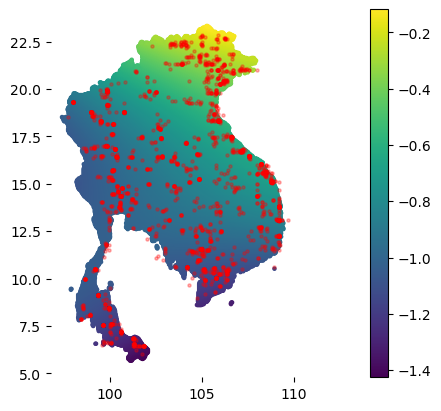

In [20]:
# Plot the predictions
fig, ax = plt.subplots()
full_model_sea_HSGP_predictions["HSGP_component"].plot("HSGP_component",legend=True, ax=ax,markersize =5)
sea_disasters_geo.plot(ax=ax, alpha = 0.3, c = "r",markersize =5, );

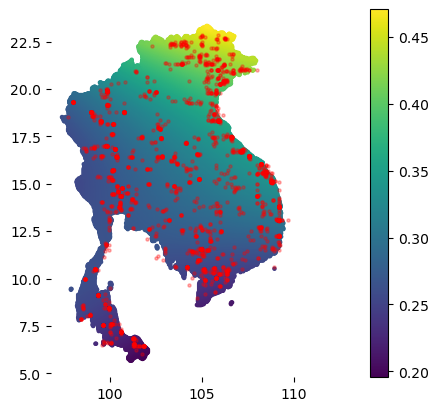

In [21]:
# Plot the predictions
fig, ax = plt.subplots()
full_model_sea_HSGP_predictions["HSGP_invlogit"].plot("HSGP_invlogit",legend=True, ax=ax,markersize =5)
sea_disasters_geo.plot(ax=ax, alpha = 0.3, c = "r",markersize =5, );

### Laos predictions

In [22]:
# We sample the predictions
with model_distance4.copy() as temp_model:
    pm.set_data({"X_gp": laos_point_grid[["lat", "lon"]],
                 "X": laos_point_grid[features],
                "iso_idx": np.full(laos_point_grid.shape[0], ISO.tolist().index("LAO") ),
                "is_island": np.full(laos_point_grid.shape[0], False ), 
                "Y": np.full(laos_point_grid.shape[0], 0 )},
                coords= {"obs_idx": laos_point_grid.index.values } )
    HSGP_invlogit = pm.Deterministic('HSGP_invlogit', pm.math.invlogit(temp_model["HSGP_component"] ))


from pymc.model.transform.optimization import freeze_dims_and_data

with freeze_dims_and_data(temp_model):
    HSGP_m_15_plot_idata = pm.sample_posterior_predictive(model_distance4_idata, var_names=["HSGP_invlogit","HSGP_component"], 
                                                         compile_kwargs= {"mode" : "JAX" })

Sampling: []


Output()

In [23]:
# Create the geopandas version of the predictions
full_model_laos_predictions = prediction_to_gpd_df(prediction_idata = HSGP_m_15_plot_idata , 
                     variables = ["HSGP_invlogit", "HSGP_component"] , 
                     points = laos_point_grid )

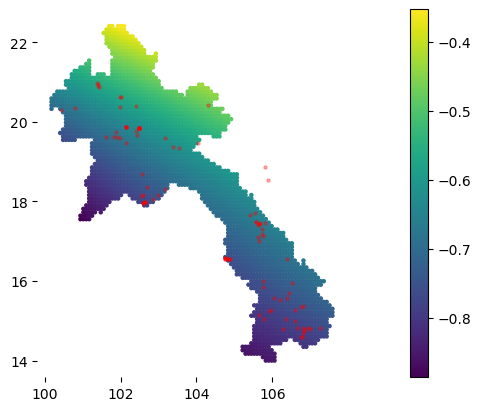

In [24]:
# Plot the predictions
fig, ax = plt.subplots()
full_model_laos_predictions["HSGP_component"].plot("HSGP_component",legend=True, ax=ax,markersize =5)
laos_disasters_geo.plot(ax=ax, alpha = 0.3, c = "r",markersize =5, );

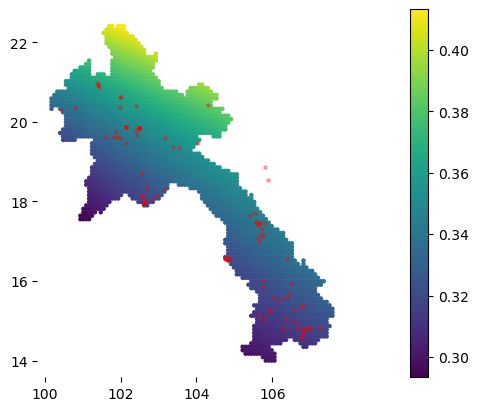

In [25]:
# Plot the predictions
fig, ax = plt.subplots()
full_model_laos_predictions["HSGP_invlogit"].plot("HSGP_invlogit",legend=True, ax=ax,markersize =5)
laos_disasters_geo.plot(ax=ax, alpha = 0.3, c = "r",markersize =5, );